In [47]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [48]:
# pandas_datareader 사용해 주가 데이터 받기
# 야후 파이낸스 사용 안정성 떨어짐. 불안하다.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import fix_yahoo_finance as yf # 야후 파이낸스이용시 패치필요

yf.pdr_override()

#한꺼번에 주석처리 ctrl+/
print(pd.__version__)
print(pdr.__version__)

start_date= pd.to_datetime('2010-01-01')
end_date= pd.to_datetime('2018-10-12')
HY= pdr.data.get_data_yahoo('005930.KS', start_date, end_date) # 현대차
#HY['Adj Close'].tail(5)
print(HY.shape)
HY.tail(5)

0.23.4
0.7.0
[*********************100%***********************]  1 of 1 downloaded
(2165, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-05,44800.0,45500.0,44550.0,44700.0,44700.0,10544165
2018-10-08,44200.0,45200.0,44200.0,44950.0,44950.0,6759464
2018-10-10,45250.0,45500.0,44500.0,45300.0,45300.0,10341349
2018-10-11,44000.0,44650.0,43100.0,43100.0,43100.0,19324537
2018-10-12,43200.0,44650.0,43200.0,44000.0,44000.0,12640906


In [49]:
HY1= HY['Close'].copy()
HY1.head()

Date
2010-01-04    16180.0
2010-01-05    16440.0
2010-01-06    16820.0
2010-01-07    16260.0
2010-01-08    16420.0
Name: Close, dtype: float64

In [87]:
def timeseries_to_supervised(data, lag=1):
    df= pd.DataFrame(data)
    columns= [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df= pd.concat(columns, axis=1) # concat([s1, s2])
    df.fillna(0, inplace= True)
    return df    

def difference(dataset, interval=1):
    diff= list()
    for i in range(interval, len(dataset)):
        value= dataset[i] - dataset[i-interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def scale(train, test):
    scaler= MinMaxScaler(feature_range=(-1,1))
    scaler= scaler.fit(train)
    #rain= train.reshape(train.shape[0], train.shape[1])
    train_scaled= scaler.transform(train)
    #est= test.reshape(test.shape[0]. test.shape[1])
    test_scaled= scaler.transform(test)
    return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, value):
    new_row= [x for x in X] + [value]
    array= np.array(new_row)
    array= array.reshape(1, len(array))
    inverted= scaler.inverse_transform(array)
    return inverted[0,-1]

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y= train[:, 0:-1], train[:,-1]
    X= X.reshape(X.shape[0], 1, X.shape[1])
    model= Sequential()
    model.add(LSTM(neurons, 
                   batch_input_shape= (batch_size, 
                                       X.shape[1], 
                                       X.shape[2]), 
                   stateful=True)
             )
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size= batch_size, 
                  verbose=0, shuffle=False)
    return model
    
def forecast_lstm(model, batch_size, X):
    X= X.reshape(1,1,len(X))
    yhat= model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [93]:
# 랜덤하게 섞은 다음 train set과 test set을 나눈다.
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(TR1, TR1_target, test_size=0.2, shuffle=False)
raw_values= HY1.values
diff_values= difference(raw_values, 1)
diff_values.head()

0    260.0
1    380.0
2   -560.0
3    160.0
4   -480.0
dtype: float64

In [94]:
supervised= timeseries_to_supervised(diff_values, 1)
supervised_values= supervised.values

In [95]:
train, test= supervised_values[0:-500], supervised_values[-500:]

In [96]:
scaler, train_scaled, test_scaled= scale(train, test)

In [ ]:
# def fit_lstm(train, batch_size, nb_epoch, neurons):
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)

In [ ]:
train_reshaped= train_scaled[:,0].reshape(len(train_scaled, 1, 1))
lstm_model.predict(train_reshaped, batch_size=1)

In [88]:
predictions= list()
for i in range(len(test_scaled)):
    X, y= test_scaled[i, 0:-1], test_scaled[i,-1]
    yhat= forecast_lstm(lstm_model, 1, X)
    yhat= invert_scale(scaler, X, yhat)
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    predictions.append(yhat)
    #expected = raw_values[len(train) + i + 1]
    



Test RMSE: 755.155


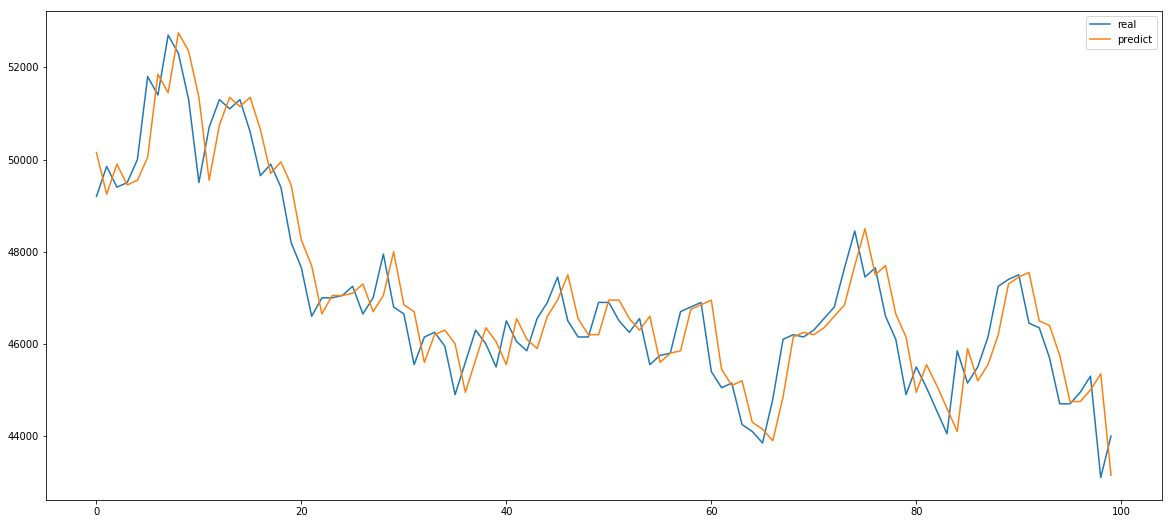

In [92]:
rmse = np.sqrt(mean_squared_error(raw_values[-500:], predictions))
print('Test RMSE: %.3f' % rmse)
fig= plt.figure(figsize=(20,9))
plt.plot(raw_values[-100:], label='real')
plt.plot(predictions[-100:], label='predict')
plt.legend()
plt.show()


In [8]:
for i in range(1,21):
    HY1.loc[:,'Close Minus'+str(i)]= HY1['Close'].shift(i)
    HY20= HY1[[x for x in HY1.columns if 'Close Minus' in x or x=='Close']]

print(HY20.shape)
HY20.head(5)

(2165, 21)


,Close,Close Minus1,Close Minus2,Close Minus3,Close Minus4,Close Minus5,Close Minus6,Close Minus7,Close Minus8,Close Minus9,...,Close Minus11,Close Minus12,Close Minus13,Close Minus14,Close Minus15,Close Minus16,Close Minus17,Close Minus18,Close Minus19,Close Minus20
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,16180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,16440.0,16180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,16820.0,16440.0,16180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,16260.0,16820.0,16440.0,16180.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,16420.0,16260.0,16820.0,16440.0,16180.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
HY20_d = HY20.dropna()
HY20_d[:5]

,Close,Close Minus1,Close Minus2,Close Minus3,Close Minus4,Close Minus5,Close Minus6,Close Minus7,Close Minus8,Close Minus9,...,Close Minus11,Close Minus12,Close Minus13,Close Minus14,Close Minus15,Close Minus16,Close Minus17,Close Minus18,Close Minus19,Close Minus20
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-01,15540.0,15680.0,16160.0,16000.0,16300.0,16840.0,16500.0,17000.0,16680.0,16460.0,...,16840.0,16540.0,15940.0,16180.0,15940.0,16420.0,16260.0,16820.0,16440.0,16180.0
2010-02-02,15440.0,15540.0,15680.0,16160.0,16000.0,16300.0,16840.0,16500.0,17000.0,16680.0,...,16860.0,16840.0,16540.0,15940.0,16180.0,15940.0,16420.0,16260.0,16820.0,16440.0
2010-02-03,15540.0,15440.0,15540.0,15680.0,16160.0,16000.0,16300.0,16840.0,16500.0,17000.0,...,16460.0,16860.0,16840.0,16540.0,15940.0,16180.0,15940.0,16420.0,16260.0,16820.0
2010-02-04,15520.0,15540.0,15440.0,15540.0,15680.0,16160.0,16000.0,16300.0,16840.0,16500.0,...,16680.0,16460.0,16860.0,16840.0,16540.0,15940.0,16180.0,15940.0,16420.0,16260.0
2010-02-05,15000.0,15520.0,15540.0,15440.0,15540.0,15680.0,16160.0,16000.0,16300.0,16840.0,...,17000.0,16680.0,16460.0,16860.0,16840.0,16540.0,15940.0,16180.0,15940.0,16420.0


In [10]:
#

# x(입력)와 y(타겟) 나누기


# train set 과 test set 나누기




In [ ]:
raw_values= series.values
diff_values= difference(raw_values, 1)
supervised= timeseries_to_supervised(diff_values, 1)